# Configurations

## Update note (what changed from v1.2 to current v1.3)
- Temperature Detrend update to v1
- 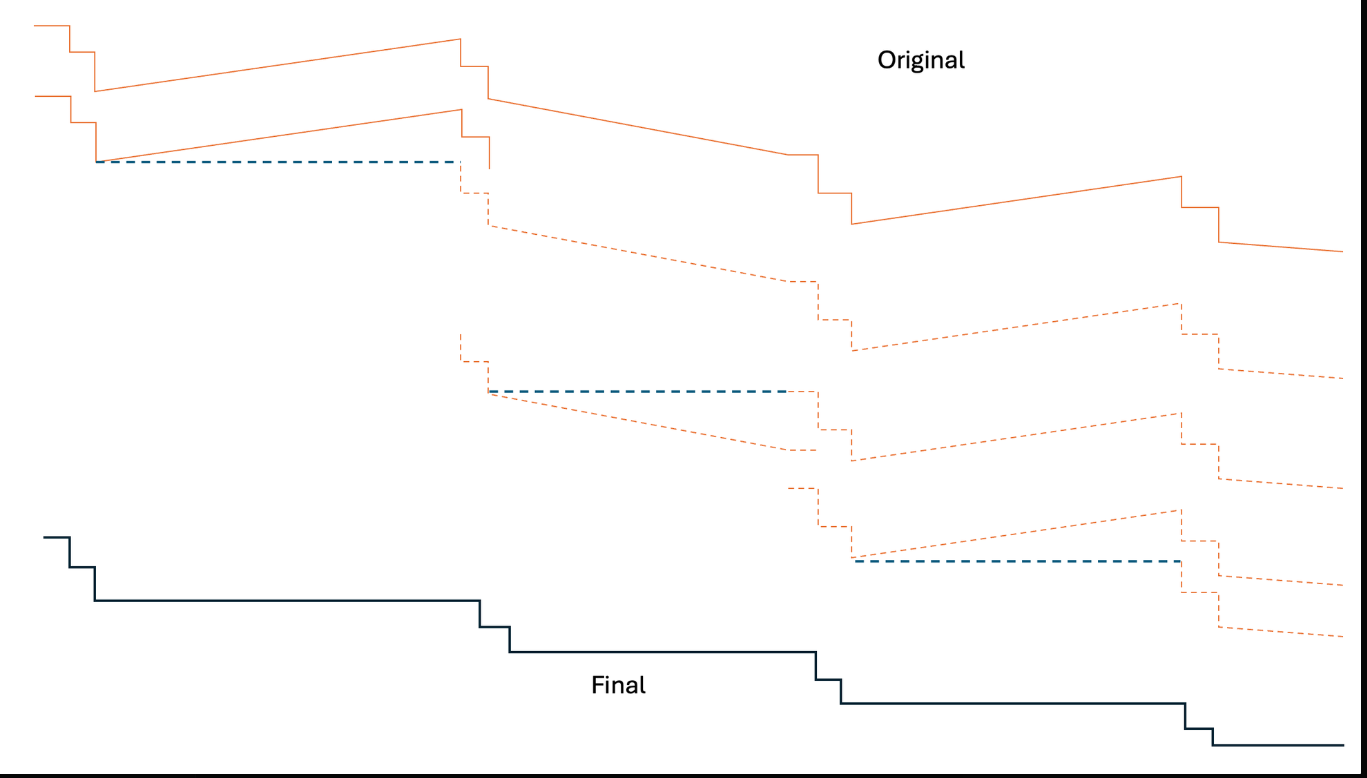

In [1]:
# ############ Helper Functions #################
# exec(open("G_Coaster_Utils_1_3.py").read())

# ######### DeviceID Panelistname Map #####
# panelist_names = {
#     '1e003' :'1e003a000b50524833343220',
#     'freya' : '330021000250525839373220',
#     '33002' : '330022001050524e35313020',

# }

# # ########## Datetime Range #####################
# # start_date= '2024-05-17 00:00:00'
# # end_date = '2024-05-20'

# ########### Hyperparameter for Coaster ####################
# sigma_threshold =  2
# taresigma_threshold = 2
# time_window_mins= 10

# drift_threshold= 0.3
# drift_length_threshold= 3
# sigma_temp = 10
# sigma_weight = 10
# constant_temperature = 20 


# ####################### process 1.1.2: Time Analysis############
# # apply_tare=False
# ######################## process 1.3.0: Isolate Short Drifts #########
# isolate_short_drifts = False  # Set to True or False based on your requirement


# auto_open=True

# # filename = "Exported results 2024-05-17_14-11-55"

# # ########### Hyperparameter for Freya ####################
# # sigma_threshold =  2
# # taresigma_threshold = 2
# # time_window_mins= 15

# # drift_threshold= 0.4
# # drift_length_threshold= 3
# # sigma = 10

# filename = 'Device_ID_330021000250525839373220_freya_onlinedata'

In [2]:
############ Helper Functions #################
exec(open("G_Coaster_Utils_1_3.py").read())

######### DeviceID Panelistname Map #####
panelist_names = {
    '1e003' :'1e003a000b50524833343220',
    'freya_48' : '330021000250525839373220',
    '33002' : '330022001050524e35313020',
    'Su' :'4b0049000550524631343520',
    'Noah' : '4b003b000550524631343520',
    'Juan' : '4b001f000550524631343520'
}

########## Datetime Range #####################
# start_date= '2024-05-17 00:00:00'
# end_date = '2024-05-20'

start_date= '2024-01-26 13:20:00'
end_date = '2024-02-17'


########### Hyperparameter ####################
sigma_threshold =  2
taresigma_threshold = 2
time_window_mins= 15

drift_threshold= 0.4
sigma_temp = 30
sigma_weight = 30

detrend_threshold = 0.5 # 1 g/day

isolate_short_drifts = False  # Set to True or False based on your requirement
drift_length_threshold= 3

auto_open=True

filename = "request2"
# filename = "Exported results 2024-05-17_14-11-55"
# filename = 'Device_ID_330021000250525839373220_freya_onlinedata'
# filename = 'Exported results 2024-05-16_19-06-45_PAST_48_HOURS 1'

In [3]:

########## Define Output Paths ################
excel_output_dir = 'output_file'
html_plots_dir = 'output_plot'

# Ensure directories exist
if not os.path.exists(excel_output_dir):
    os.makedirs(excel_output_dir)
if not os.path.exists(html_plots_dir):
    os.makedirs(html_plots_dir)


# Load Cloud DATA (Future update with query)

In [4]:
path = './'
extension = '.xlsx'

filename_data = path+filename+extension

df_raw = pd.read_excel(filename_data)
df_raw['datetime'] = pd.to_datetime(df_raw['eventWakeupTime'], format='%Y-%m-%d %H:%M:%S')
df_raw.drop(columns='eventWakeupTime', inplace=True)
df_raw = df_raw.sort_values(by=['datetime']).reset_index().rename(columns={'index': 'orig_idx','MeanWeight':'mean_weight_g','SampleSigma':'sample_sigma'})
df_raw['datetime'] = df_raw['datetime'] - pd.Timedelta(hours=4)
print(len(df_raw))
try:
    if start_date and end_date:
        mask = (df_raw['datetime'] > start_date) & (df_raw['datetime'] <= end_date)
        df_raw = df_raw.loc[mask]
except NameError:
    # If start_date or end_date are not defined, just pass
    pass

49744
26005


# Main Loop + Export Outputs

In [5]:
# Initialize
all_analysis_results = []
interaction_results = []

for panelist in panelist_names:
    # Construct file paths
    print(f"Now Processing {panelist} data.")
    excel_output_path = os.path.join(excel_output_dir, f'{panelist}_results.xlsx')
    
############################################################################################

    device_id = panelist_names[panelist]
    df_sensor = df_raw[df_raw['deviceID'] == device_id]
    df_sensor = df_sensor.drop_duplicates()
    df_sensor.reset_index(drop=True, inplace=True)

    print(len(df_sensor))
######################## Time Analysis (process 1.1.0) ###############################

    
    
    df_sensor, interaction_df = analyze_sensor_data(df_sensor,
                                                    sigma_threshold,
                                                    taresigma_threshold, 
                                                    # apply_tare=apply_tare,
                                                   )
######################## Mark Drifts (process 1.2.1) ##################################
    df_sensor = mark_drifts(df_sensor,drift_threshold)
    df_sensor['smoothed_temperature'] = apply_gaussian_smoothing(df_sensor['McuTemperature'], sigma_temp)

######################## # process 1.3.0: Isolate Short Drifts  #######################
    if isolate_short_drifts:
        short_drifts = check_drift(df_sensor, drift_length_threshold)
        main_data = df_sensor[~df_sensor['drift_flag'].isin(short_drifts['drift_flag'])]
    else:
        main_data = df_sensor
        short_drifts = pd.DataFrame()
######################## Detrend Temp Dependency(process 1.4.1) ###############################
    drift_dfs = [main_data[main_data['drift_flag'] == i] for i in main_data['drift_flag'].unique() if not np.isnan(i)]
    modified_drift_dfs = []
    
    # Loop over each drift dataframe
    for drift_df in drift_dfs:
        if len(drift_df) <= 1:
            # Skip drifts with only one point
            continue
        
        # Apply Gaussian smoothing
        drift_df['smoothed_mean_weight'] = apply_gaussian_smoothing(drift_df['mean_weight_g'], sigma_weight)
        drift_df['shifted_weight'] = drift_df['smoothed_mean_weight'].shift(8)
        
        # Calculate differences and ratios excluding the first row
        drift_df['temp_diff'] = drift_df['smoothed_temperature'].diff().fillna(0)
        drift_df['weight_diff'] = drift_df['smoothed_mean_weight'].diff().fillna(0)
        drift_df['shifted_weight_diff'] = drift_df['shifted_weight'].diff().fillna(0)
    
        # Exclude the first row to avoid zero differences
        drift_df = drift_df.iloc[1:]
    
        ############################################
        # Fit the linear models for each drift segment
        X_shifted = sm.add_constant(drift_df['temp_diff'])
        X = sm.add_constant(drift_df['temp_diff'])
        Y_shifted = drift_df['shifted_weight_diff']
        Y = drift_df['weight_diff']
        ############################################
    
        model_shifted = sm.OLS(Y_shifted, X_shifted)
        model = sm.OLS(Y, X)
        
        results_shifted = model_shifted.fit()
        results = model.fit()
        ############################################
        slope_shifted = results_shifted.params['temp_diff']
        intercept_shifted = results_shifted.params['const']
        
        # Get the slope and intercept of the fitted line for the unshifted case
        slope = results.params['temp_diff']
        intercept = results.params['const']
        ############################################
        # Calculate the new weight columns for each drift segment
        drift_df['fitted_line_shifted'] = results_shifted.predict(X_shifted)
        drift_df['fitted_line'] = results.predict(X)
        
        # Calculate the residuals for each drift segment
        drift_df['residuals_shifted'] = Y_shifted - drift_df['fitted_line_shifted']
        drift_df['residuals'] = Y - drift_df['fitted_line']
        ############################################
        # Establish a starting point for each drift segment
        reference_weight = drift_df['smoothed_mean_weight'].iloc[0]
        
        # Calculate the cumulative sum of fitted differences for each drift segment
        drift_df['cumulative_fitted_diff'] = drift_df['fitted_line'].cumsum()
        drift_df['cumulative_fitted_diff_shifted'] = drift_df['fitted_line_shifted'].cumsum()
        
        # Create the new weight columns for each drift segment
        drift_df['new_weight'] = reference_weight + drift_df['cumulative_fitted_diff']
        drift_df['new_weight_shifted'] = reference_weight + drift_df['cumulative_fitted_diff_shifted']
    
        # Calculate the difference between actual temperature and constant temperature
        temp_diff_from_constant = drift_df['smoothed_temperature'] - constant_temperature
        
        # Calculate the weight adjustment needed
        weight_adjustment_due_to_temp = slope * temp_diff_from_constant
        
        # Adjust the weight data
        drift_df['adjusted_weight'] = drift_df['new_weight'] - weight_adjustment_due_to_temp
        drift_df['adjusted_weight_shifted'] = drift_df['new_weight_shifted'] - weight_adjustment_due_to_temp
    
        # Add the modified drift dataframe to the list
        modified_drift_dfs.append(drift_df)
    
    # Reintegrate Short Drifts if Isolation is Enabled
    if modified_drift_dfs:
        all_modified_drifts = pd.concat(modified_drift_dfs, ignore_index=True)
        if isolate_short_drifts:
            combined_df = pd.concat([all_modified_drifts, short_drifts], ignore_index=True)
        else:
            combined_df = all_modified_drifts

        combined_df.sort_values('datetime', inplace=True)
        
        combined_df_file_path = os.path.join(excel_output_dir, f"{panelist}_combined_df_v3_drift_{drift_threshold}_sigma_weight_{sigma_weight}-{sigma_temp}.xlsx")
        combined_df.to_excel(combined_df_file_path, index=False)

        combined_df = detrend_weight(combined_df, threshold=detrend_threshold)

        
        results_process4 = analyze_drift_transitions(combined_df)
        results_process4_file_path = os.path.join(excel_output_dir, f"{panelist}_output_summary_v3_drift_{drift_threshold}_sigma_weight_{sigma_weight}-{sigma_temp}.xlsx")
        results_process4.to_excel(results_process4_file_path, index=False)
        main_fig_path = os.path.join(html_plots_dir, f"{panelist}_main_plot_v3_drift_{drift_threshold}_sigma_weight-temp_{sigma_weight}-{sigma_temp}.html")
        generate_and_save_plots(combined_df, interaction_df, results_process4, panelist, html_plots_dir, time_window_mins, auto_open)
        print(f"Output summary table saved to {results_process4_file_path}")

    else:
        print("No Data to concatenate, so skipping...")
    print("-------------------------------------------------------")


Now Processing 1e003 data.
0
time diff threshold set to be nan
time diff threshold set to be nan
No Data to concatenate, so skipping...
-------------------------------------------------------
Now Processing freya_48 data.
0
time diff threshold set to be nan
time diff threshold set to be nan
No Data to concatenate, so skipping...
-------------------------------------------------------
Now Processing 33002 data.
0
time diff threshold set to be nan
time diff threshold set to be nan
No Data to concatenate, so skipping...
-------------------------------------------------------
Now Processing Su data.
5639
time diff threshold set to be 5.417666666666666
Plot saved to output_plot\Su_main_plot_drift_0.4_sigma_weight-temp_30-30.html
Output summary table saved to output_file\Su_output_summary_drift_0.4_sigma_weight_30-30.xlsx
time diff threshold set to be 5.417666666666666


KeyError: 'const'